# SIMPLE LSTM MODEL
> Created Nov. 2024 <br>
> Nikhil Bisht<br>

# Functions and Definitions

In [84]:
# standard system modules
import os, sys
import h5py 
# standard module for tabular data
import pandas as pd

# standard module for array manipulation
import numpy as np

# standard statistical module
import scipy.stats as st

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
import xgboost as xgb
import tables

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

In [101]:
DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_ML_dataset_AllData_AutoEnc.h5'
CORESET  = '/data/cb1/nbisht/anvil_scratch/projects/128/B2/datasets/nb101_all_frames.h5'
MODELFILE = 'nnmodel.dict'

NTRAIN = 1600000
NVALID =  100000 #roughly
NTEST  =  300000 

TARGET = ['Vx_f', 'Vy_f', 'Vz_f','Density_f']
POS_FEAT = ['X_f', 'Y_f', 'Z_f','X_i', 'Y_i', 'Z_i']
FEATURES = ['Vx_i', 'Vy_i', 'Vz_i','Density_i']

FRAMES = [0,10,20,30,40,50,60,70,80,90,100,110,120,125]

NUM_X_TRAIN = 13


#DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')

print(f'Available device: {str(DEVICE):4s}')
print(n_input, n_output)

Available device: cpu 
4 4


In [169]:
def plot_timeseries(data, fname,  skip = 500, predicted_data = None,
                ftsize=14):
    
    # create an empty figure
    fig = plt.figure(figsize=(5, 4))
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title('Timeseries', fontsize=16)

    # axis limits
    x = np.arange(0,len(data.columns.tolist()))
    ax.set_xlim((x[0], x[-1]))
    ax.set_xlabel('Time', fontsize=14)
    
    ax.set_ylabel('Density', fontsize=14)
    ax.set_yscale('log')
    
    for i in data.index.to_list()[::skip]:
        ax.plot(x, data.loc[i].to_numpy(), lw = 0.1, c='black', zorder=1)
    
    if predicted_data!=None:
        predicted_data = predicted_data[0]
        x = x[NUM_X_TRAIN:]
        for i in predicted_data.index.to_list()[::skip]:
            ax.scatter(x, predicted_data.loc[i].to_numpy(), c='red', s=10, zorder=2)

    ax.grid(True, which="both", linestyle='-', zorder=0)

    
    fig.tight_layout()
    plt.savefig(fname)
    plt.show()

In [110]:
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

# Load Sample

In [39]:
#get data and prepare sample
df_timeseries = pd.DataFrame([])
f =  h5py.File(DATAFILE, 'r')
for frame_num in FRAMES:
    column_name = "Density_"+str(frame_num)
    print("frame", frame_num,)
    f_frame = f[str(frame_num)]
    if frame_num == 0:
        df_timeseries['Particle_id'] = f_frame['Particle_id'][()]
        df_timeseries['Particle_id'] = df_timeseries['Particle_id'].astype('int32')
        df_timeseries[column_name] = f_frame['Density'][()]
        df_timeseries = df_timeseries.set_index('Particle_id')
    else:
        appended_series = pd.Series(f_frame['Density'][()], index=np.array(f_frame['Particle_id'][()], dtype=int), name = column_name)
        df_timeseries.insert(len(df_timeseries.columns), column_name, appended_series)

f.close()

#get core stuff
df_core_pids =[]
with h5py.File(CORESET, 'r') as f:
    tm = f['track_manager']
    df_core_pids = tm['particle_ids'][()]

#Now we split noncore and core
df_timeseries_core = df_timeseries.loc[df_core_pids]
df_timeseries_noncore = df_timeseries.drop(df_core_pids)

print(len(df_timeseries_core))
df_timeseries_core.head()

frame 0
frame 10
frame 20
frame 30
frame 40
frame 50
frame 60
frame 70
frame 80
frame 90
frame 100
frame 110
frame 120
frame 125
117364


,Density_0,Density_10,Density_20,Density_30,Density_40,Density_50,Density_60,Density_70,Density_80,Density_90,Density_100,Density_110,Density_120,Density_125
Particle_id,,,,,,,,,,,,,,
1405,0.183325,0.428764,0.277539,0.838506,0.868581,1.993545,4.175687,5.045288,5.693549,4.328129,6.710278,17.521617,17.192313,20.716482
1488,1.196013,1.006710,0.974011,0.795669,0.895291,0.963084,4.106851,39.037887,59.666656,107.898600,207.381202,1785.495870,75240.767562,60016.565728
1489,1.441835,1.338888,0.850971,0.901985,0.814556,1.276136,3.372227,14.318357,16.489768,24.091400,38.184089,106.025167,2225.126397,45319.180241
1490,1.203609,1.017623,0.941309,0.925280,0.752385,0.523608,0.952401,9.867965,18.045372,18.643145,31.241282,57.621241,38185.587182,47555.385578
1531,0.196255,0.242984,0.239841,0.284573,0.270198,0.550364,5.901490,6.292285,3.806236,6.348706,8.418560,17.521617,23.406687,20.716482


In [40]:
print(len(df_timeseries_noncore))
df_timeseries_noncore.head()

1979788


,Density_0,Density_10,Density_20,Density_30,Density_40,Density_50,Density_60,Density_70,Density_80,Density_90,Density_100,Density_110,Density_120,Density_125
Particle_id,,,,,,,,,,,,,,
0,0.524400,1.618523,0.867386,0.837293,0.627009,0.557469,0.476659,0.465411,0.625973,1.589325,1.075431,1.285047,11.929422,13.814165
1,0.317997,0.573314,0.581710,0.516869,0.472357,0.442156,0.364704,0.406775,0.457466,1.778120,1.237673,0.839313,1.515161,1.147726
2,0.447816,0.480452,0.360186,0.315196,0.327020,0.362455,0.324820,0.581995,0.650383,0.995528,1.430341,1.431558,1.259315,1.189952
3,0.582043,0.385223,0.390798,0.265446,0.391496,0.301256,0.371378,0.340880,0.357316,0.339697,0.304106,0.507239,0.670554,0.667628
4,0.331791,0.347462,0.352164,0.265446,0.331970,0.304523,0.272405,0.264219,0.258058,0.399513,0.379373,0.422013,0.439116,0.442949


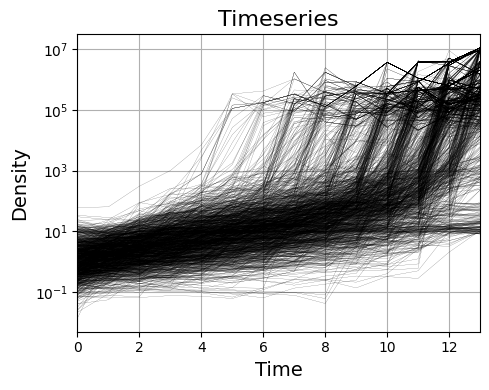

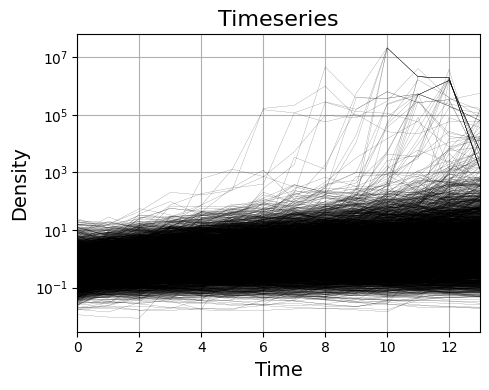

In [76]:
plot_timeseries(df_timeseries_core,'Core_Timeseries.png', skip = 100)
plot_timeseries(df_timeseries_noncore,'NonCore_Timeseries.png', skip = 500)

In [158]:
# train-test split for time series
timeseries = df_timeseries_core #train on cores
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
X_train, y_train = torch.Tensor([train[train.columns[:NUM_X_TRAIN]].to_numpy().T]).T, torch.Tensor([train[train.columns[NUM_X_TRAIN:]].to_numpy().T]).T
X_test, y_test = torch.Tensor([test[test.columns[:NUM_X_TRAIN]].to_numpy().T]).T, torch.Tensor([test[test.columns[NUM_X_TRAIN:]].to_numpy().T]).T
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)
n_epochs = 2000

In [159]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        y_pred = torch.reshape(y_pred[:, -1, :],y_batch.shape)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 5 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        y_pred = torch.reshape(y_pred[:, -1, :],y_train.shape)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        y_pred = torch.reshape(y_pred[:, -1, :],y_test.shape)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
torch.save(model.state_dict(), MODELFILE)

/tmp/ipykernel_535771/4188882612.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred, y_train))
/tmp/ipykernel_535771/4188882612.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred, y_test))


Epoch 0: train RMSE 4837886.5000, test RMSE 3854950.2500
Epoch 5: train RMSE 4837543.5000, test RMSE 3854668.2500
Epoch 10: train RMSE 4837200.0000, test RMSE 3854386.0000
Epoch 15: train RMSE 4836857.0000, test RMSE 3854103.5000
Epoch 20: train RMSE 4836513.5000, test RMSE 3853821.2500
Epoch 25: train RMSE 4836170.5000, test RMSE 3853539.2500
Epoch 30: train RMSE 4835827.5000, test RMSE 3853257.5000
Epoch 35: train RMSE 4835485.0000, test RMSE 3852976.0000
Epoch 40: train RMSE 4835143.0000, test RMSE 3852694.0000
Epoch 45: train RMSE 4834800.0000, test RMSE 3852412.5000
Epoch 50: train RMSE 4834457.0000, test RMSE 3852130.7500
Epoch 55: train RMSE 4834115.0000, test RMSE 3851849.5000
Epoch 60: train RMSE 4833772.0000, test RMSE 3851568.2500
Epoch 65: train RMSE 4833429.5000, test RMSE 3851286.5000
Epoch 70: train RMSE 4833087.5000, test RMSE 3851005.7500
Epoch 75: train RMSE 4832745.0000, test RMSE 3850724.5000
Epoch 80: train RMSE 4832403.0000, test RMSE 3850443.5000
Epoch 85: train 

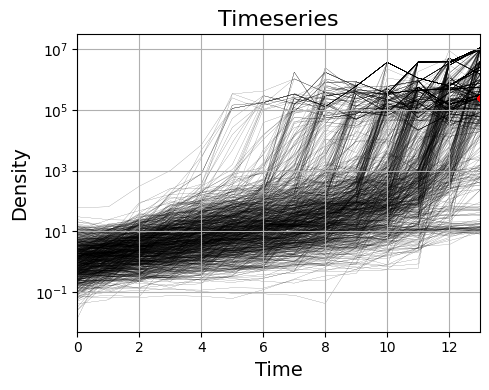

In [170]:
with torch.no_grad():
    # shift train predictions for plotting
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]

plot_timeseries(train,'SimpleLSTM_prediction.png', skip = 100, predicted_data=[pd.DataFrame(y_pred)])

In [171]:
y_pred

tensor([[243386.2969],
        [243386.2969],
        [243386.2969],
        ...,
        [243386.2969],
        [243386.2969],
        [243386.2969]])